# Introduction to MDAnalysis

In this notebook we introduce various features of MDAnalysis.

You can follow along or work through it in your own time later. We will explain most of what is shown here in more detail in the following tutorials.

## Background: Adenylate kinase
As an example we will analyze the enzyme *adenylate kinase*. It catalyzes the reaction ATP + AMP $\rightleftharpoons$ 2 ADP. It undergoes a *conformational transition* between a closed conformation (e.g. PDB code 1AKE) and an open conformation (e.g. 4AKE) [1], even in the absence of substrate.

![AdK conformations (from [2])](figs/angle_defs.png)

Sampling large conformational is challenging with standard equilibrium MD. Therefore we used an enhanced sampling method ("dynamic importance sampling", DIMS) to generate transitions between closed and open apo AdK [2, 3] in addition to "brute force" equilibrium MD (on PSC Anton).



1. S. L. Seyler and O. Beckstein. Sampling of large conformational transitions: Adenylate kinase as a testing ground. Molec. Simul., 40(10–11):855–877, 2014. doi: [10.1080/08927022.2014.919497](https://doi.org/10.1080/08927022.2014.919497)
2. O. Beckstein, E. J. Denning, J. R. Perilla, and T. B. Woolf. Zipping and unzipping of adenylate kinase: Atomistic insights into the ensemble of open ↔ closed transitions. 394(1):160–176, 2009. doi: [10.1016/j.jmb.2009.09.009](https://doi.org/10.1016/j.jmb.2009.09.009)
3. S. L. Seyler, A. Kumar, M. F. Thorpe, and O. Beckstein. Path similarity analysis: A method for quantifying macromolecular pathways. PLoS Comput Biol, 11(10):e1004568, 10 2015. doi: [10.1371/journal.pcbi.1004568](https://doi.org/10.1371/journal.pcbi.1004568)

## Setup 

### Load packages 

In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import nglview as nv

In [2]:
print(mda.__version__)

0.19.2


### Load data

* AdK equilibrium trajectory: `adk` (from `adk = fetch_adk_equilibrium()`)
* transition between closed and open AdK from DIMS MD: `PSF`, `DCD`

In [3]:
from MDAnalysisData.datasets import fetch_adk_equilibrium
from MDAnalysis.tests.datafiles import PSF, DCD

adk = fetch_adk_equilibrium()

## PDB structures 

#### Closed conformation

Load from PDB (or fall back to local copy of the PDB file).

In [4]:
try:
    uc = mda.fetch_mmtf('1AKE')
except IOError:
    uc = mda.Universe("../data/1ake.pdb")

In [5]:
uc

<Universe with 3816 atoms>

In [7]:
nv.show_mdanalysis(uc)

/Users/oliver/anaconda3/envs/workshop/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:902: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


NGLWidget()

In [8]:
pclosed = uc.select_atoms("protein and segid A")
pclosed

<AtomGroup with 1661 atoms>

In [9]:
nv.show_mdanalysis(pclosed)

NGLWidget()

In [10]:
print(pclosed[:10])

<AtomGroup [<Atom 1: N of type N of resname MET, resid 1 and segid A and altLoc >, <Atom 2: CA of type C of resname MET, resid 1 and segid A and altLoc >, <Atom 3: C of type C of resname MET, resid 1 and segid A and altLoc >, <Atom 4: O of type O of resname MET, resid 1 and segid A and altLoc >, <Atom 5: CB of type C of resname MET, resid 1 and segid A and altLoc >, <Atom 6: CG of type C of resname MET, resid 1 and segid A and altLoc >, <Atom 7: SD of type S of resname MET, resid 1 and segid A and altLoc >, <Atom 8: CE of type C of resname MET, resid 1 and segid A and altLoc >, <Atom 9: N of type N of resname ARG, resid 2 and segid A and altLoc >, <Atom 10: CA of type C of resname ARG, resid 2 and segid A and altLoc >]>


#### Open conformation

In [11]:
try:
    uo = mda.fetch_mmtf('4AKE')
except IOError:
    uo = mda.Universe("../data/4ake.pdb")

In [12]:
nv.show_mdanalysis(uo)

NGLWidget()

In [13]:
popen = uo.select_atoms("protein and segid A")

In [14]:
nv.show_mdanalysis(popen)

NGLWidget()

#### Visualize open and closed together 

First superimpose

In [15]:
from MDAnalysis.analysis.align import alignto

In [16]:
alignto(popen, pclosed)

/Users/oliver/anaconda3/envs/workshop/lib/python3.6/site-packages/MDAnalysis/analysis/align.py:1065: SelectionWarning: Reference and trajectory atom selections do not contain the same number of atoms: 
atoms:    N_ref=1661, N_traj=1656
but we attempt to create a valid selection (use strict=True to disable this heuristic).
  warnings.warn(msg, category=SelectionWarning)


(23.805724332251824, 7.208983484994985)

In [17]:
popen.segments.segids = 'O'
pclosed.segments.segids = 'C'

In [18]:
merged = mda.Merge(pclosed, popen)

In [19]:
merged.segments

<SegmentGroup with 2 segments>

In [20]:
nv.show_mdanalysis(merged)

NGLWidget()

## Analysis of DIMS trajectory

In [93]:
PSF, DCD

('/Users/oliver/anaconda3/envs/workshop/lib/python3.6/site-packages/MDAnalysisTests/data/adk.psf',
 '/Users/oliver/anaconda3/envs/workshop/lib/python3.6/site-packages/MDAnalysisTests/data/adk_dims.dcd')

In [94]:
u = mda.Universe(PSF, DCD)

In [95]:
u.atoms

<AtomGroup with 3341 atoms>

In [96]:
u.atoms.residues

<ResidueGroup with 214 residues>

In [97]:
print(u.atoms.residues)

<ResidueGroup [<Residue MET, 1>, <Residue ARG, 2>, <Residue ILE, 3>, ..., <Residue ILE, 212>, <Residue LEU, 213>, <Residue GLY, 214>]>


In [26]:
u.atoms.segments

<SegmentGroup with 1 segment>

In [27]:
print(u.atoms.segments)

<SegmentGroup [<Segment 4AKE>]>


### Visualization 

In [28]:
for attr in ("altLocs", "icodes", "occupancies", "tempfactors"):
    u.add_TopologyAttr(attr)

(We add a whole bunch of attributes (with default values) to the `Universe` which `nv.show_mdanalysis()` currently expects because it reads MDAnalysis data as PDB format. If you don't do it, you get a warning that is harmless and can be ignored.)

In [98]:
nv.show_mdanalysis(u)

/Users/oliver/anaconda3/envs/workshop/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:902: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/Users/oliver/anaconda3/envs/workshop/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:902: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/Users/oliver/anaconda3/envs/workshop/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:902: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/Users/oliver/anaconda3/envs/workshop/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:902: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


NGLWidget(count=98)

### Quantify conformational transition 

In [99]:
ca = u.select_atoms("protein and name CA")
ca

<AtomGroup with 214 atoms>

In [100]:
ca.atoms

<AtomGroup with 214 atoms>

In [101]:
ca.residues

<ResidueGroup with 214 residues>

#### Distances 

Experimental FRET labels: distances

![FRET distances](figs/fret_distances_adk.png)

* I52 - K145
* A55 - V169
* A127 - A194

Calculate the C$_\beta$ distances as proxies for the spin-label distances.

In [102]:
donors = u.select_atoms("name CB").select_atoms("resname ILE and resid 52", 
                                       "resname ALA and resid 55",
                                       "resname ALA and resid 127")

In [103]:
acceptors = u.select_atoms("name CB").select_atoms("resname LYS and resid 145", 
                                       "resname VAL and resid 169",
                                       "resname ALA and resid 194")

In [104]:
r = donors.positions - acceptors.positions
r

array([[ 34.585167 , -26.43769  ,   2.6458828],
       [  1.1011238, -16.838428 , -16.44395  ],
       [-33.41602  , -17.490902 ,  -6.3704085]], dtype=float32)

In [105]:
d = np.linalg.norm(r, axis=1)
d

array([43.61291 , 23.561594, 38.25107 ], dtype=float32)

In [106]:
def FRETdist(donors, acceptors):
    return np.linalg.norm(donors.positions - acceptors.positions, axis=1)

In [107]:
FRETdist(donors, acceptors)

array([43.61291 , 23.561594, 38.25107 ], dtype=float32)

In [108]:
distances = []
times = []
for ts in u.trajectory:
    d = FRETdist(donors, acceptors)
    distances.append(d)
    times.append(ts.time)
distances = np.array(distances)
times = np.array(times)

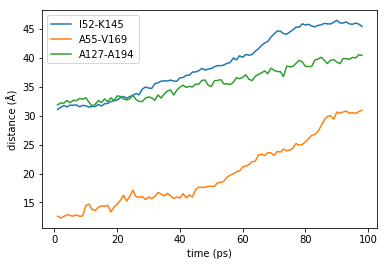

In [109]:
plt.plot(times, distances)
plt.legend(("I52-K145", "A55-V169", "A127-A194"))
plt.xlabel("time (ps)")
plt.ylabel(r"distance (Å)");

#### Radius of gyration

$$
R_\mathrm{gyr} = \sqrt{\frac{1}{M}\sum_{i=1}^{N} m_i(\mathbf{r}_i - \mathbf{R})^2}
$$

In [79]:
protein = u.select_atoms("protein")

rg = []
times = []
for ts in u.trajectory:
    rg.append(protein.radius_of_gyration())
    times.append(ts.time)
rg = np.array(rg)
times = np.array(times)

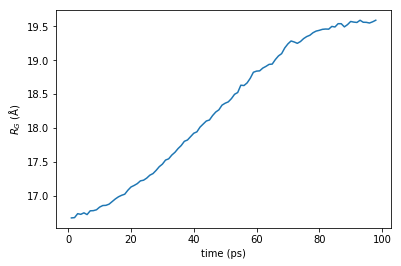

In [80]:
plt.plot(times, rg)
plt.xlabel("time (ps)")
plt.ylabel(r"$R_G$ (Å)");

#### RMSD 

In [69]:
from MDAnalysis.analysis import rms

In [110]:
ca = u.select_atoms("protein and name CA")

R = rms.RMSD(ca)
R.run(verbose=True)

In [77]:
R.rmsd[:4]

array([[0.00000000e+00, 9.99999912e-01, 7.37561408e-07],
       [1.00000000e+00, 1.99999982e+00, 4.23430296e-01],
       [2.00000000e+00, 2.99999974e+00, 5.93658621e-01],
       [3.00000000e+00, 3.99999965e+00, 7.36831301e-01]])

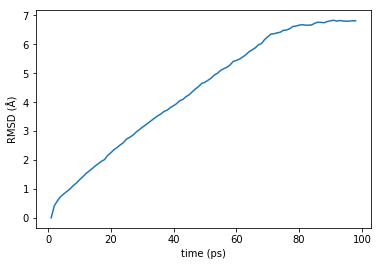

In [111]:
plt.plot(R.rmsd[:, 1], R.rmsd[:, 2])
plt.xlabel("time (ps)")
plt.ylabel("RMSD (Å)");

## Analysis of equilibrium MD trajectory
The 1 µs trajectory did not include any bias. 

In [83]:
u2 = mda.Universe(adk.topology, adk.trajectory)

In [87]:
ca2 = u2.select_atoms("protein and name CA")

R2 = rms.RMSD(ca2)
R2.run()

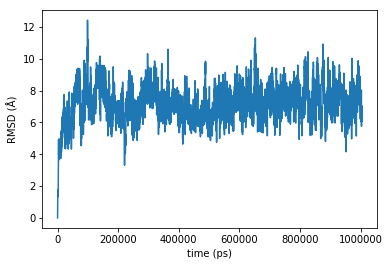

In [88]:
plt.plot(R2.rmsd[:, 1], R2.rmsd[:, 2])
plt.xlabel("time (ps)")
plt.ylabel("RMSD (Å)");

In [89]:
donors2 = u2.select_atoms("name CB").select_atoms("resname ILE and resid 52", 
                                       "resname ALA and resid 55",
                                       "resname ALA and resid 127")

In [90]:
acceptors2 = u2.select_atoms("name CB").select_atoms("resname LYS and resid 145", 
                                       "resname VAL and resid 169",
                                       "resname ALA and resid 194")

In [91]:
distances2 = []
times2 = []
for ts in u2.trajectory:
    d = FRETdist(donors2, acceptors2)
    distances2.append(d)
    times2.append(ts.time)
distances2 = np.array(distances2)
times2 = np.array(times2)

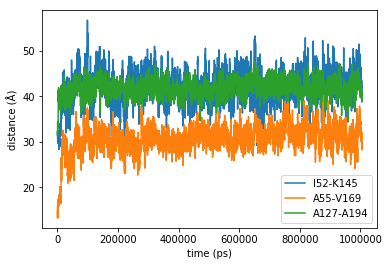

In [92]:
plt.plot(times2, distances2)
plt.legend(("I52-K145", "A55-V169", "A127-A194"))
plt.xlabel("time (ps)")
plt.ylabel(r"distance (Å)");